# A simple Movie Recommendation process based on plot description

### Goal of the project

For this project, given a movie and its plot description, I'll attempt a recommendation process that will recommend similar movies. For example, if I'm a fan of the Star Wars movies and would like to checkout similar movies, this recommender process could help me decide what I'll be playing for my ext movie night!

But what's really interesting about this approach? I'm not going to build a complicated deep learning model and have the model train on millions of movie plots. I would need a start of the art deep learning architecture and like isn't a lot to have on my plate, I would have to deal with practical issues like class imbalance.



### Motivation for this project and practical application

I want to try and achieve a decent and practical recommender system (not just for movies) with absolutely no training and minimal data. Companies like Amazon or Netflix probably have the data, time and resources to build an accurate recommender system. But can the same model be used 1 year down the line? 2 years down the line? Probably not. Products evolve over time. Companies try to bring in the latest trends in fashion, technology or entertainment to woo customers and increase their clientele.

How would startups or smaller-sized companies work? Would they have access to a lot of data? Probably! Do they have the time and resources to keep reinventing the wheel? Probably not. It's entirely possible for them to not have a lot of data to begin with. Even in the age of the internet, data is scarce to come by sometimes. This is my motivation. To try and obtain great results with minimal data!

### Outline of the entire process:

1. Obtain the data using __[this kaggle dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset)__ .
2. Clean the data for analysis.

   (Above steps have been accomplished)
3. Remove stop words from plot descriptions.
4. Convert the descriptions column to a list and have that run through __[Tensorflow's Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-large/3)__ . This computes a numpy array of length 512 for each movie plot.
5. Calculate the cosine similarities matrix using the above generated numpy array for the 12 most similar movies.
6. Plot the images of the movies using the __[TMBD API](https://developers.themoviedb.org/3/getting-started/introduction)__.
7. Analyze genres and possibly the plot descriptions as well.



### A brief intrduction to the Universal Sentence Encoder

This encoder encodes words, phrases, sentences or even paragraphs into high dimensional space. This model was trained extensively using various data sources to accomlish various NLP (Natural Language Processing tasks). 

The input word, phrase, or sentence is converted to a vector of size 512. This vector is represented though a numpy array. What's so special about this encoder is that it maintains context similarity in a semantic sense which can be very useful. For ex, we have the three sentences:

1) How old are you?
2) How are you?
3) What is your age

We know that sentences 1 and 3 are closer in a semantic sense. While sentences 1 and 2 differ only a word, they differ greatly in contrast. The universal sentence encoder was trained such that we compute any mathematical similarity between the 3 sentences, sentences 1 and 3 will be closer than 1 and 2. That's incredible isn't it?

For this project, I'll be using the __[universal-sentence-encoder-large](https://tfhub.dev/google/universal-sentence-encoder-large/3)__. This model was trained with a transformer encoder. We can hope to achive a high accuracy with this model but the tradeoff would be the computing time and memory usage. A lighter version of the universal sentence encoder can be found __[here](https://tfhub.dev/google/universal-sentence-encoder/2)__

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

In [3]:
import cv2
import urllib.request
import requests

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

### STEP 1

In [4]:
new_df = pd.read_csv('clean_movie_data.csv')

In [5]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0    imdb_id               original_title  \
0           0  tt0114709                    Toy Story   
1           1  tt0113497                      Jumanji   
2           2  tt0113228             Grumpier Old Men   
3           3  tt0114885            Waiting to Exhale   
4           4  tt0113041  Father of the Bride Part II   

                     genres                                      modified_desc  
0   Animation,Comedy,Family  led woody andy's toys live happily room andy's...  
1  Adventure,Fantasy,Family  siblings judy peter discover enchanted board g...  
2            Romance,Comedy  family wedding reignites ancient feud next-doo...  
3      Comedy,Drama,Romance  cheated mistreated stepped women holding breat...  
4                    Comedy  george banks recovered daughter's wedding rece...

In [6]:
new_df = new_df.drop('Unnamed: 0', axis =1)

In [7]:
new_df = new_df.reset_index(drop = True)

In [14]:
new_df['genres'] = new_df['genres'].str.replace('Science,Fiction', 'Sci-Fi')

In [15]:
len(new_df)

27412

In [16]:
data = new_df.dropna()

In [17]:
len(data)

25750

In [18]:
genres_list = []

In [19]:
for j in data['genres']:     #Looping over the genres column of the dataframe.
    words = j.split(',')            #The different genres have been separated by a comma. Hence this string will be split by identifying the ',' character.
    for k in words:                 #Since the different list of words will be identified, the for loop will be used to iterate through all the different words in this list.
        if k not in genres_list:    #Only uniquely identified strings will be appended.
            genres_list.append(k)

In [20]:
genres_list

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Sci-Fi',
 'Mystery',
 'War',
 'Music',
 'TV',
 'Movie']

In [21]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                       modified_desc  
0  led woody andy's toys live happily room andy's...  
1  siblings judy peter discover enchanted board g...  
2  family wedding reignites ancient feud next-doo...  
3  cheated mistreated stepped women holding breat...  
4  george banks recovered daughter's wedding rece...

In [22]:
data = data.reset_index(drop = True)

In [23]:
data.head()

imdb_id               original_title                    genres  \
0  tt0114709                    Toy Story   Animation,Comedy,Family   
1  tt0113497                      Jumanji  Adventure,Fantasy,Family   
2  tt0113228             Grumpier Old Men            Romance,Comedy   
3  tt0114885            Waiting to Exhale      Comedy,Drama,Romance   
4  tt0113041  Father of the Bride Part II                    Comedy   

                                       modified_desc  
0  led woody andy's toys live happily room andy's...  
1  siblings judy peter discover enchanted board g...  
2  family wedding reignites ancient feud next-doo...  
3  cheated mistreated stepped women holding breat...  
4  george banks recovered daughter's wedding rece...

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [24]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"

In [25]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [26]:
all_descriptions = data['modified_desc'].tolist()

In [27]:
set_1 = all_descriptions[:10000]
set_2 = all_descriptions[10000:20000]
set_3 = all_descriptions[20000:]
movies_sublist = [set_1, set_2, set_3]

In [28]:
tf.logging.set_verbosity(tf.logging.ERROR)
j=0
for i in movies_sublist:
    j += 1
    with tf.device('/device:CPU:0'):      
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            description_embeddings  =  session.run(embed(i))
            np.save('set_' + str(j) + '.npy', description_embeddings)            
            print(j)
#np.save('embed_10k.npy', description_embeddings)

1
2
3


In [29]:
s1 = np.load('set_1.npy')
s2 = np.load('set_2.npy')
s3 = np.load('set_3.npy')

In [30]:
fill = np.concatenate([s1, s2, s3])

In [31]:
fill.shape

(25750, 512)

In [32]:
movies_similarity = cosine_similarity(fill)

In [33]:
movies_similarity .shape

(25750, 25750)

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [34]:
words_siilar = movies_similarity

In [35]:
words_siilar.shape

(25750, 25750)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [36]:
KEY = 'a997c6a74e5b2d33c1e329b556a1769d'

In [37]:
def get_images(imdb_id):
    for num in range(1):
        IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' # The URL pattern for the movie posters. With the key and IMDB ID, the generated URL can be used to download the posters.
        r = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdb_id)) # KEY is the API key and i[0] identifies the unique IMDB ID.
        api_response = r.json() # The generated response is converted to json.
    
        try:                     
            posters = api_response['posters'] # Contains information about the movie posters to be downloaded.
        except KeyError:
            continue
       # print('error for ' + imdb_id)
                  # 'continue' can only be used in a loop. This command moves on the next row if no vible information is found.
    
        base_url = 'http://image.tmdb.org/t/p/'  # The base url for the TMDB API
        max_size = 'w342'                        # Movie sizes are available in different sizes: w342, w500, and orignal. w342 images are smaller than w500 and 'original' images.
        try:           
            rel_path = posters[0]['file_path']   # Some movies have multiple posters. A few movies have up to 9 posters or so. What's even more bothersome is that some of them are duplicates. Hence, onlyone image per movie will be used.
        except IndexError:
            continue
        url = "{0}{1}{2}".format(base_url, max_size, rel_path) # If the movie does have a poster, this step generated the movie poster url
    #print(url)
    
        try:   
            resp = urllib.request.urlopen(url)                        # This step read the image from the url
            image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
            new_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except urllib.error.URLError as e:
            continue
            
        return new_img

In [30]:
poster = get_images('tt0114709')

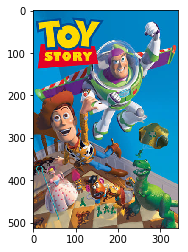

In [31]:
plt.imshow(poster)

In [38]:
def get_related_movies(imdbid, data = data):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    movie = data.loc[data.imdb_id == imdbid].index
    index_list = []
    for k in movie:
        index_list.append(k)
    index_num = index_list[0]
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:13] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    #print(similar_prod_arr)
    prod_img = get_images(imdbid) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,16))
    plt.subplot(5,3,2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        img = get_images(data['imdb_id'].loc[i]) # Retrieves the images of all items related to the product
        plt.subplot(5,3,j) 
        try:
            plt.imshow(img) # Plots the images
            plt.xlabel('Related movie ID: ' + str(i))
            plt.xticks([])
            plt.yticks([])
            j+=1
        except:
            continue

In [42]:
data.loc[data.original_title.str.contains('Man of Steel')]

imdb_id original_title                           genres  \
13859  tt0770828   Man of Steel  Action,Adventure,Fantasy,Sci-Fi   

                                           modified_desc  
13859  young boy learns extraordinary powers earth yo...

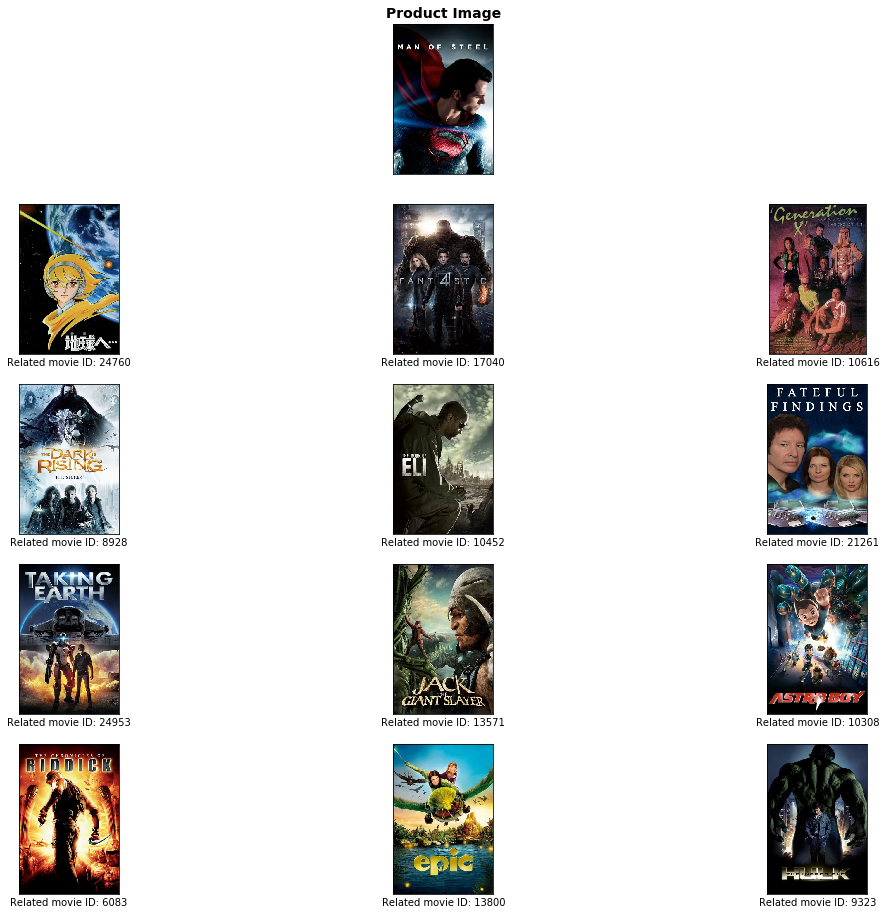

In [44]:
get_related_movies('tt0770828')

In [74]:
data.loc[8816]

imdb_id                                                   tt0418279
original_title                                         Transformers
genres                             Adventure,Science,Fiction,Action
modified_desc     young teenager sam witwicky becomes involved a...
Name: 8816, dtype: object

In [38]:
data['genres'].loc[[8816,16248, 24975, 5134, 11262, 9908]]

8816     Adventure,Science,Fiction,Action
16248                     Science,Fiction
24975              Science,Fiction,Action
5134               Action,Science,Fiction
11262     Action,Thriller,Science,Fiction
9908      Action,Science,Fiction,Thriller
Name: genres, dtype: object

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

In [54]:
data.loc[data.original_title.str.contains('The Incredibles')]

imdb_id   original_title                             genres  \
6471  tt0317705  The Incredibles  Action,Adventure,Animation,Family   

                                          modified_desc  
6471  bob parr given superhero days log time insuran...

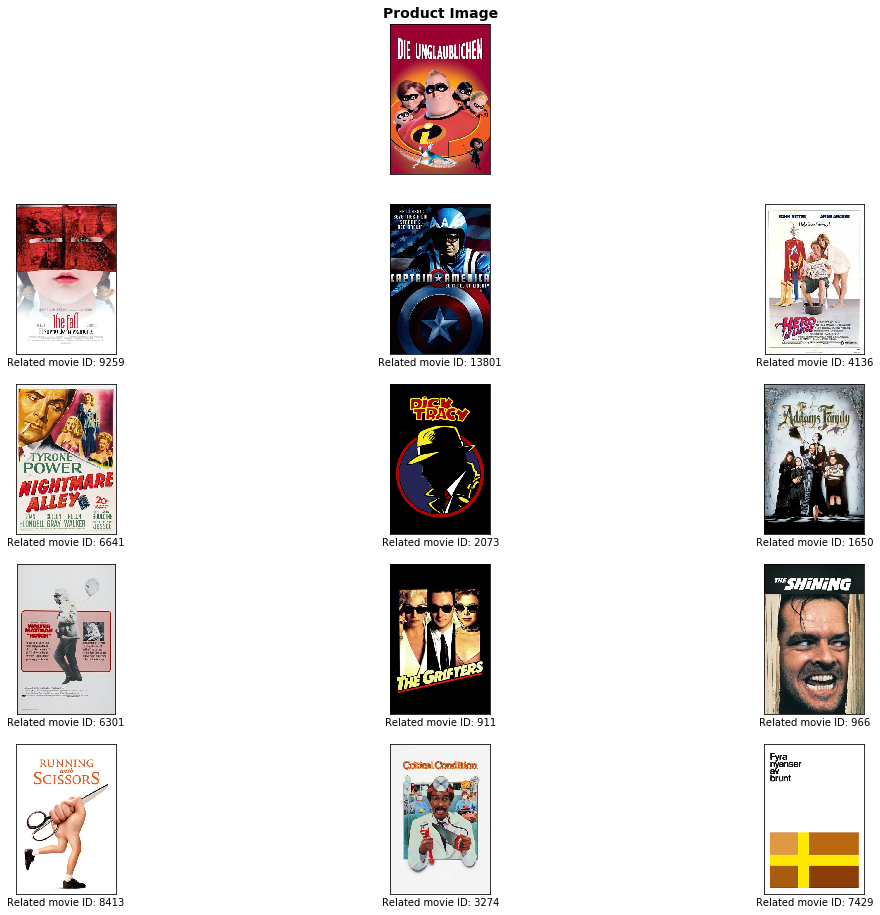

In [45]:
get_related_movies('tt0317705')

In [46]:
data['genres'].loc[[9259, 4136, 6641, 2073, 1650, 6301, 911, 966, 8413, 7429]]

9259                   Adventure,Fantasy,Drama
4136                       Action,Comedy,Drama
6641                                     Drama
2073    Adventure,Action,Comedy,Thriller,Crime
1650                     Horror,Comedy,Fantasy
6301                              Comedy,Drama
911                                Crime,Drama
966                            Horror,Thriller
8413                              Drama,Comedy
7429                              Comedy,Drama
Name: genres, dtype: object

In [48]:
data['genres'].loc[data.imdb_id == 'tt2345759']

24797    Thriller,Action,Adventure
Name: genres, dtype: object

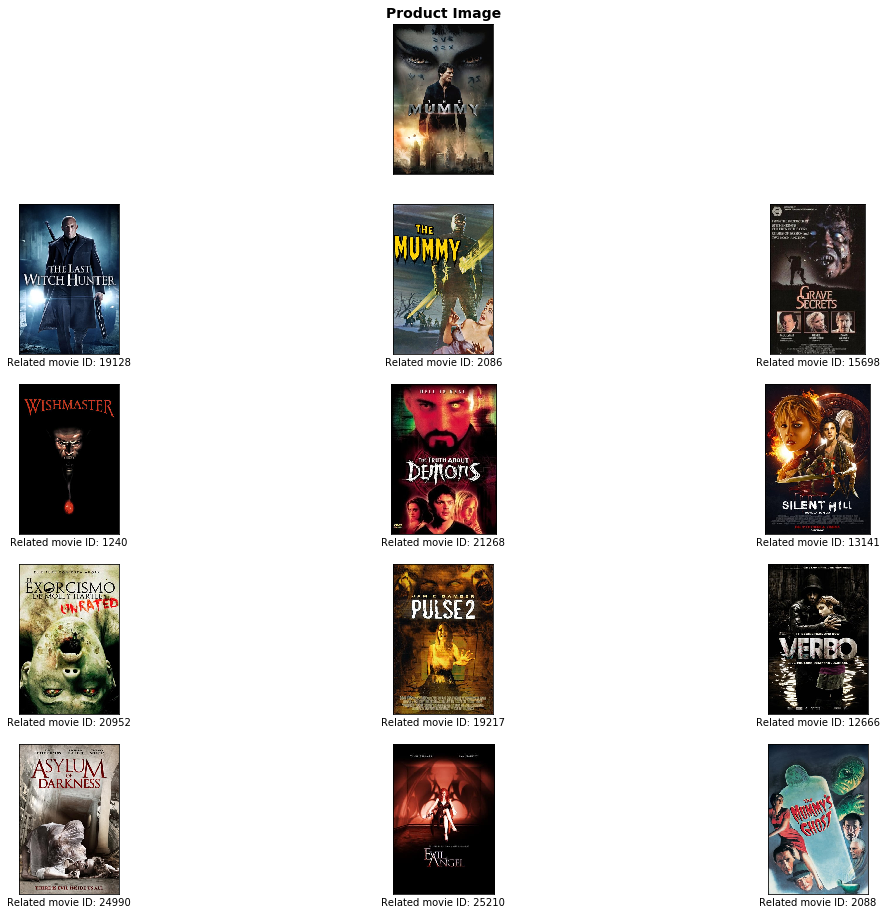

In [46]:
get_related_movies('tt2345759')

In [84]:
data['genres'].loc[[19128, 4229, 16658, 20952, 21223, 13141, 22449,21268, 1240]]

19128    Fantasy,Action,Adventure
4229     Action,Fantasy,Adventure
16658             Thriller,Horror
20952                      Horror
21223            Adventure,Sci-Fi
13141     Thriller,Horror,Mystery
22449                      Horror
21268                      Horror
1240                       Horror
Name: genres, dtype: object

In [102]:
data.loc[data.imdb_id == 'tt0429493']

imdb_id original_title                                  genres  \
10841  tt0429493     The A-Team  Thriller,Action,Adventure,Comedy,Crime   

                                           modified_desc  
10841  group iraq war veterans goes run us military f...

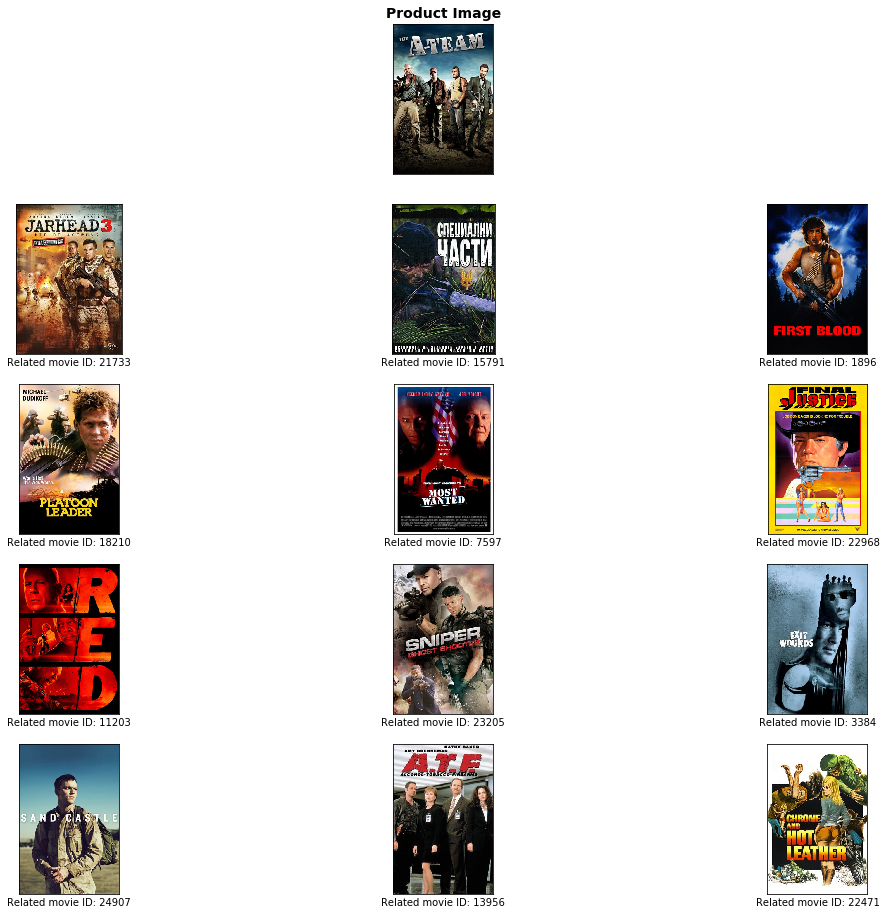

In [47]:
get_related_movies('tt0429493')

In [49]:
data['genres'].loc[[21733, 15791, 1896, 18210, 7597, 22968, 24907, 22471]]

21733                 Action,Drama,War
15791              War,Action,Thriller
1896     Action,Adventure,Thriller,War
18210                        Drama,War
7597                   Action,Thriller
22968               Action,Crime,Drama
24907                        Drama,War
22471                  Action,Thriller
Name: genres, dtype: object

In [51]:
data.loc[data.original_title.str.contains('Inception')]

imdb_id original_title  \
10916  tt1375666      Inception   

                                                  genres  \
10916  Action,Thriller,Science-Fiction,Mystery,Adventure   

                                           modified_desc  
10916  cobb skilled thief commits corporate espionage...

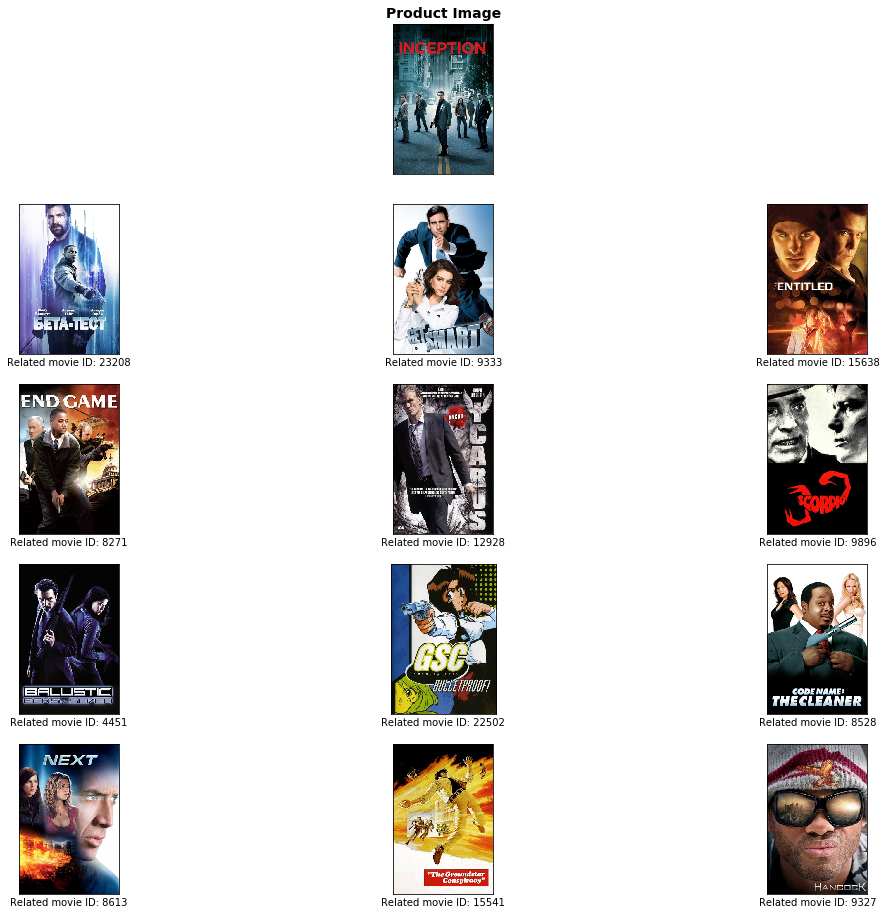

In [48]:
get_related_movies('tt1375666')

In [79]:
data['genres'].loc[[13396, 9985, 3010, 13793,12398, 10700, 2977, 5445, 20749, 15586, 23715,922]]

13396                     Sci-Fi,Thriller
9985         Crime,Drama,Thriller,Mystery
3010     Adventure,Horror,Sci-Fi,Thriller
13793                            Thriller
12398      Adventure,Action,Crime,Mystery
10700                              Comedy
2977               Horror,Sci-Fi,Thriller
5445                 Comedy,Drama,Mystery
20749                            Thriller
15586                      Drama,Thriller
23715                       Horror,Sci-Fi
922                         Comedy,Sci-Fi
Name: genres, dtype: object

In [53]:
data.loc[data.original_title.str.contains('Guardians of')]

imdb_id                  original_title  \
15327  tt2015381         Guardians of the Galaxy   
17043  tt3896198  Guardians of the Galaxy Vol. 2   

                                        genres  \
15327         Action,Science-Fiction,Adventure   
17043  Action,Adventure,Comedy,Science-Fiction   

                                           modified_desc  
15327  light years earth 26 years abducted peter quil...  
17043  guardians must fight keep newfound family toge...

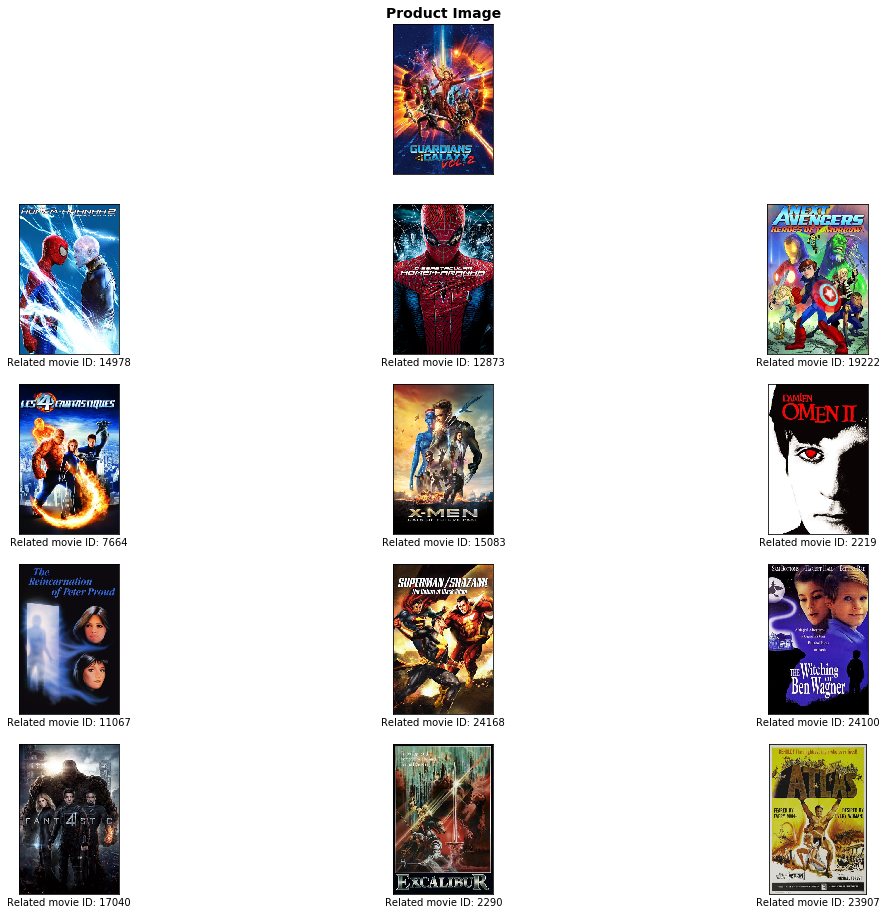

In [49]:
get_related_movies('tt3896198')

In [74]:
data['genres'].loc[[15461, 2219, 11067]]

15461                          Comedy
2219     Action,Drama,Horror,Thriller
11067                  Horror,Mystery
Name: genres, dtype: object

In [120]:
data.loc[data.original_title.str.contains('The Silence of the Lambs')]

imdb_id            original_title                genres  \
502  tt0102926  The Silence of the Lambs  Crime,Drama,Thriller   

                                         modified_desc  
502  fbi trainee clarice starling ventures maximum-...

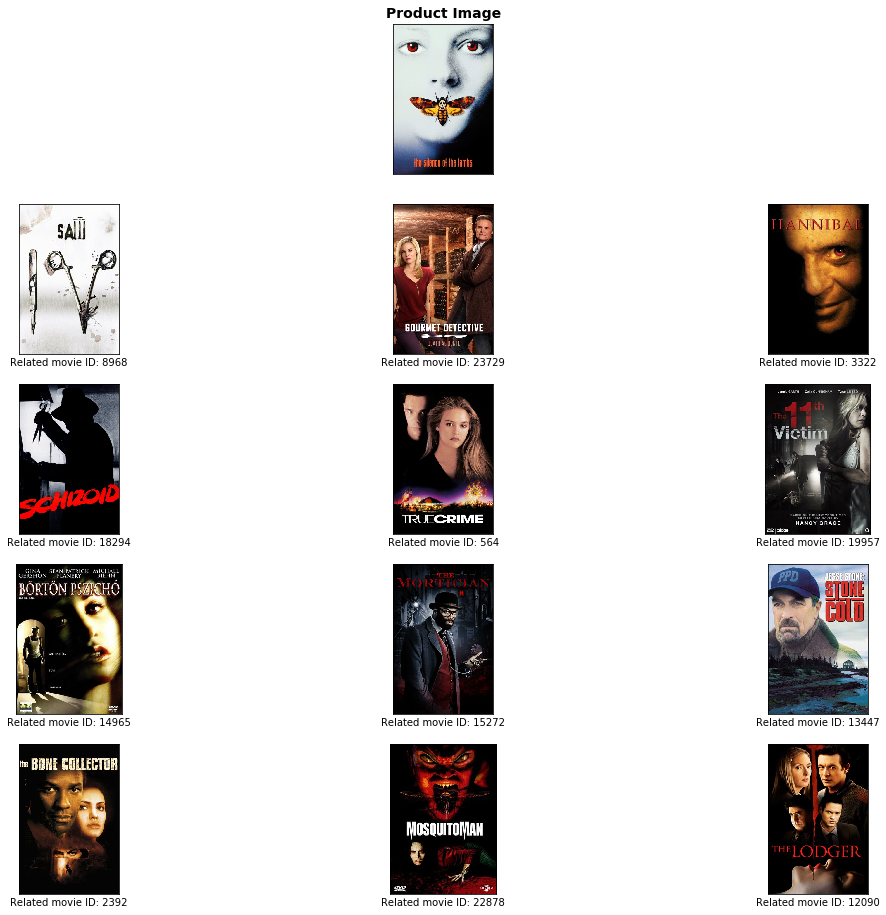

In [50]:
get_related_movies('tt0102926')

In [51]:
data['genres'].loc[[8968, 23729, 3322, 18294, 564, 19957, 10520, 15272, 13477, 14965, 15272, 12090]]

8968            Horror,Thriller,Crime
23729    Drama,TV,Movie,Mystery,Crime
3322      Crime,Drama,Thriller,Horror
18294                  Horror,Mystery
564            Crime,Mystery,Thriller
19957                        Thriller
10520    Crime,Drama,Mystery,Thriller
15272                  Thriller,Drama
13477                          Comedy
14965            Drama,Crime,Thriller
15272                  Thriller,Drama
12090         Horror,Mystery,Thriller
Name: genres, dtype: object

In [52]:
data.loc[data.original_title.str.contains('Me Before You')]

imdb_id original_title         genres  \
21732  tt2674426  Me Before You  Drama,Romance   

                                           modified_desc  
21732  small town girl caught dead-end jobs high-prof...

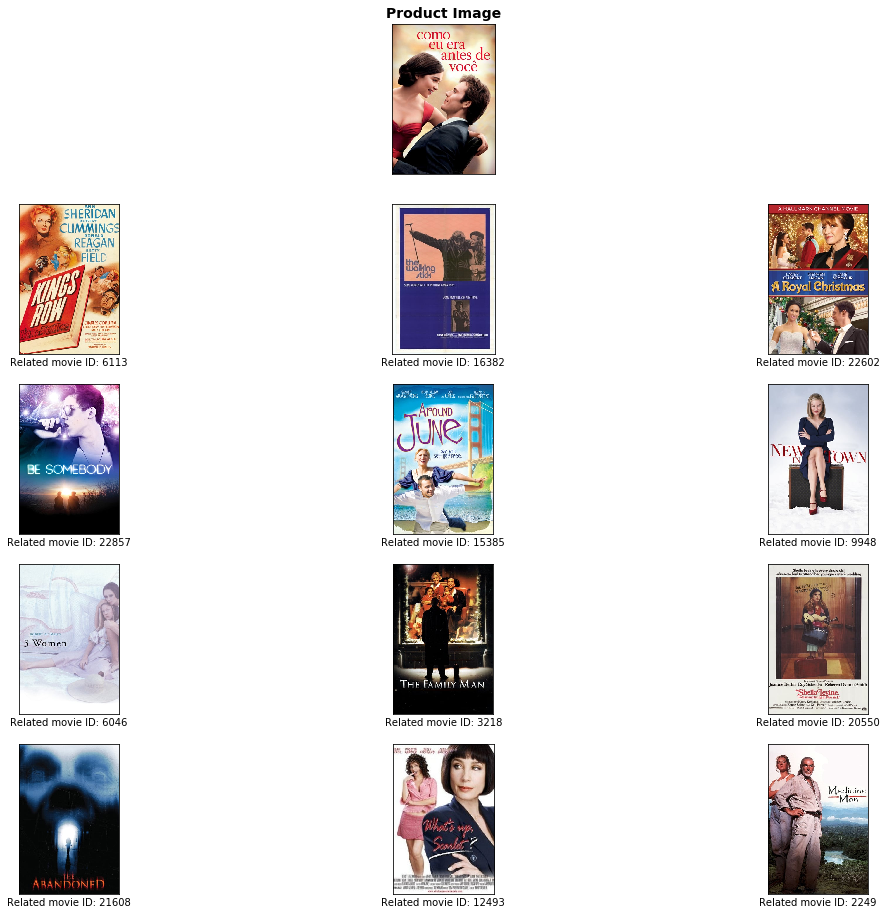

In [53]:
get_related_movies('tt2674426')

In [71]:
data['genres'].loc[[6113, 5033, 16827, 22857, 16382, 9948, 11634, 15385, 2249, 24504]]

6113               Romance,Drama,Mystery
5033                               Drama
16827                      Romance,Drama
22857               Drama,Comedy,Romance
16382                Crime,Drama,Romance
9948                              Comedy
11634                     Romance,Comedy
15385    Animation,Drama,Fantasy,Romance
2249                           Adventure
24504      Comedy,Fantasy,Horror,Romance
Name: genres, dtype: object

In [61]:
data.loc[data.original_title.str.contains('Hangover')]

imdb_id         original_title                       genres  \
9855   tt0037761        Hangover Square  Crime,Drama,Horror,Thriller   
9937   tt1119646           The Hangover                       Comedy   
11797  tt1411697   The Hangover Part II                       Comedy   
13798  tt1951261  The Hangover Part III                       Comedy   

                                                overview  \
9855   A composer who can't control his creative temp...   
9937   When three friends finally come to after a rau...   
11797  The Hangover crew heads to Thailand for Stu's ...   
13798  This time, there's no wedding. No bachelor par...   

                                            overview_new  
9855   composer can't control creative temperament tu...  
9937   three friends finally come raucous night bache...  
11797  hangover crew heads thailand stu's wedding dis...  
13798  time there's wedding bachelor party could go w...

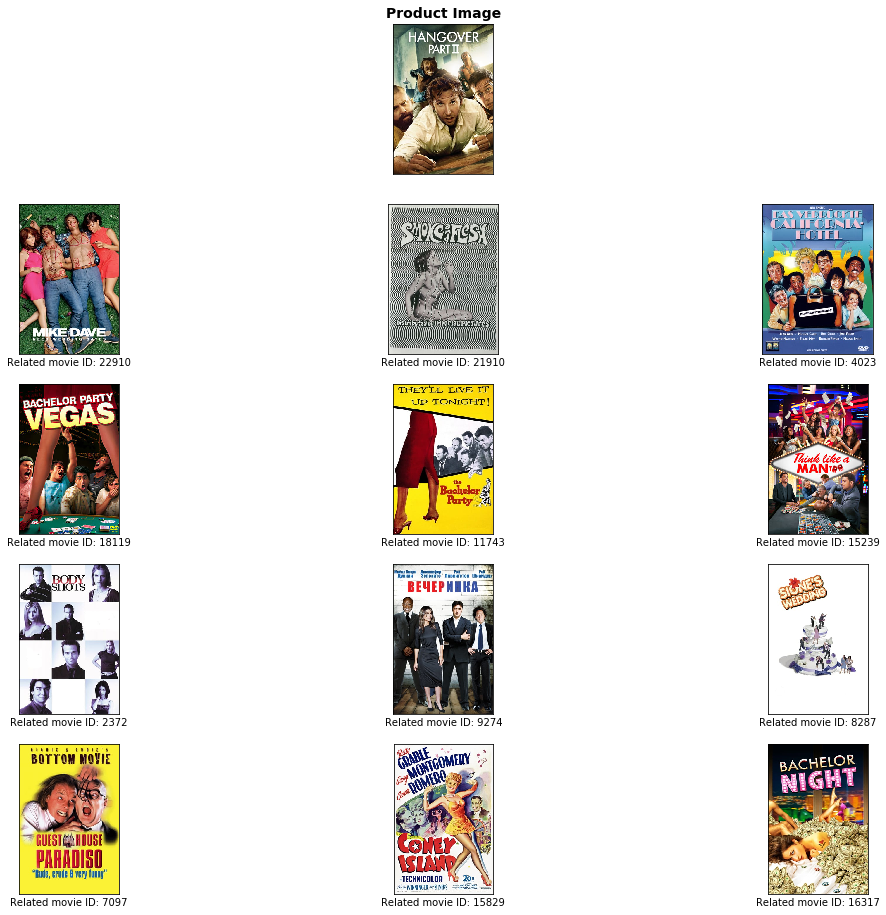

In [54]:
get_related_movies('tt1411697')

In [68]:
data['genres'].loc[[21910, 11743, 13781, 9274, 15829]]

21910                                    Drama
11743                                    Drama
13781    Drama,Comedy,Thriller,Mystery,Romance
9274                                    Comedy
15829                                   Comedy
Name: genres, dtype: object

In [146]:
data.loc[data.original_title.str.contains('Gravity')]

imdb_id   original_title                          genres  \
2847   tt0156460  Defying Gravity                   Drama,Romance   
11943  tt0104693  Laws of Gravity                    Action,Drama   
14155  tt1454468          Gravity  Science,Fiction,Thriller,Drama   

                                           modified_desc  
2847   john keitel wrote film based personal undergra...  
11943  jimmy jon couple brooklyn guys somehow never f...  
14155  dr ryan stone brilliant medical engineer first...

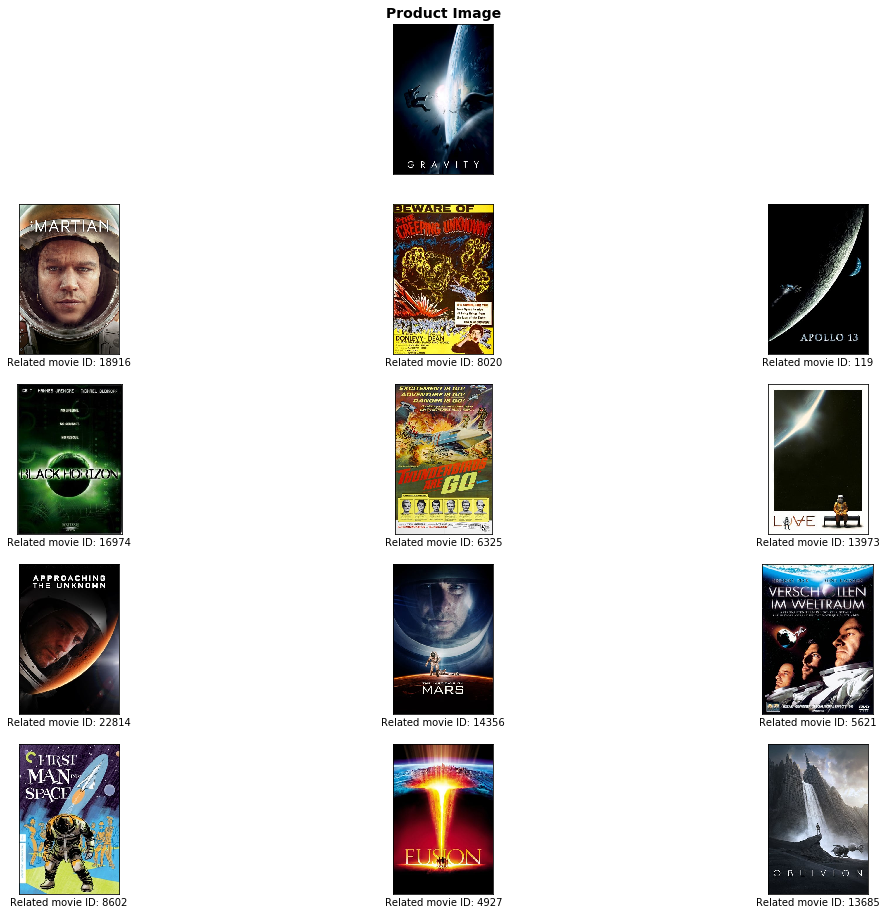

In [55]:
get_related_movies('tt1454468')

In [66]:
data['genres'].loc[[8602, 23800, 10369, 8020]]

8602                          Drama,Horror,Sci-Fi
23800                   Thriller,Adventure,Sci-Fi
10369    Sci-Fi,Animation,Family,Comedy,Adventure
8020                                Horror,Sci-Fi
Name: genres, dtype: object

In [34]:
data.loc[10403]

imdb_id                                                   tt0499549
original_title                                               Avatar
genres                     Action,Adventure,Fantasy,Science-Fiction
modified_desc     22nd century paraplegic marine dispatched moon...
Name: 10403, dtype: object

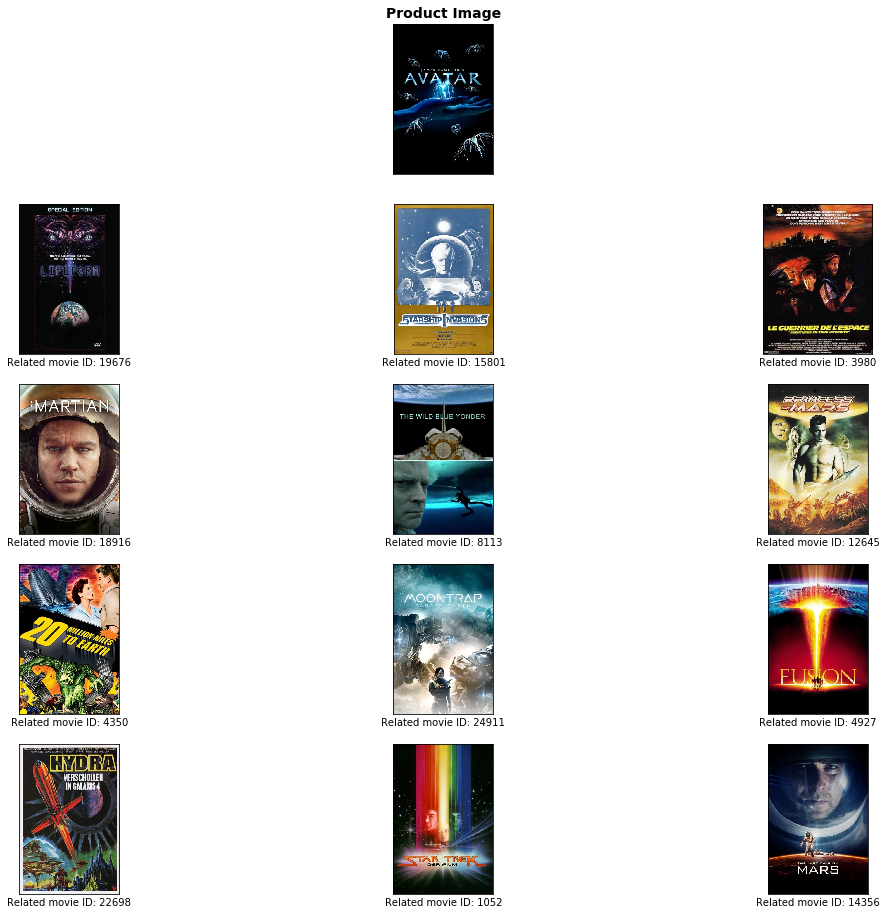

In [56]:
get_related_movies('tt0499549')

In [65]:
data['genres'].loc[[19676, 15801, 10690, 14356, 12645, 4927, 2116, 2667, 8113, 923, 1052]]

19676                      Sci-Fi,Romance
15801                              Sci-Fi
10690                       Horror,Sci-Fi
14356              Sci-Fi,Thriller,Horror
12645                  Fantasy,Sci-Fi,War
4927     Action,Thriller,Adventure,Sci-Fi
2116               Horror,Sci-Fi,Thriller
2667                               Sci-Fi
8113                         Drama,Sci-Fi
923         Horror,Action,Thriller,Sci-Fi
1052             Sci-Fi,Adventure,Mystery
Name: genres, dtype: object

In [58]:
data.loc[data.original_title.str.contains('Rapunzel')]

imdb_id      original_title            genres  \
18756  tt0313255  Barbie as Rapunzel  Animation,Family   

                                           modified_desc  
18756  long long ago time magic dragons lived girl na...

In [52]:
data.loc[5106]

imdb_id                                                   tt0165982
original_title                     Sinbad: Legend of the Seven Seas
genres                                   Family,Animation,Adventure
overview          The sailor of legend is framed by the goddess ...
Name: 5106, dtype: object

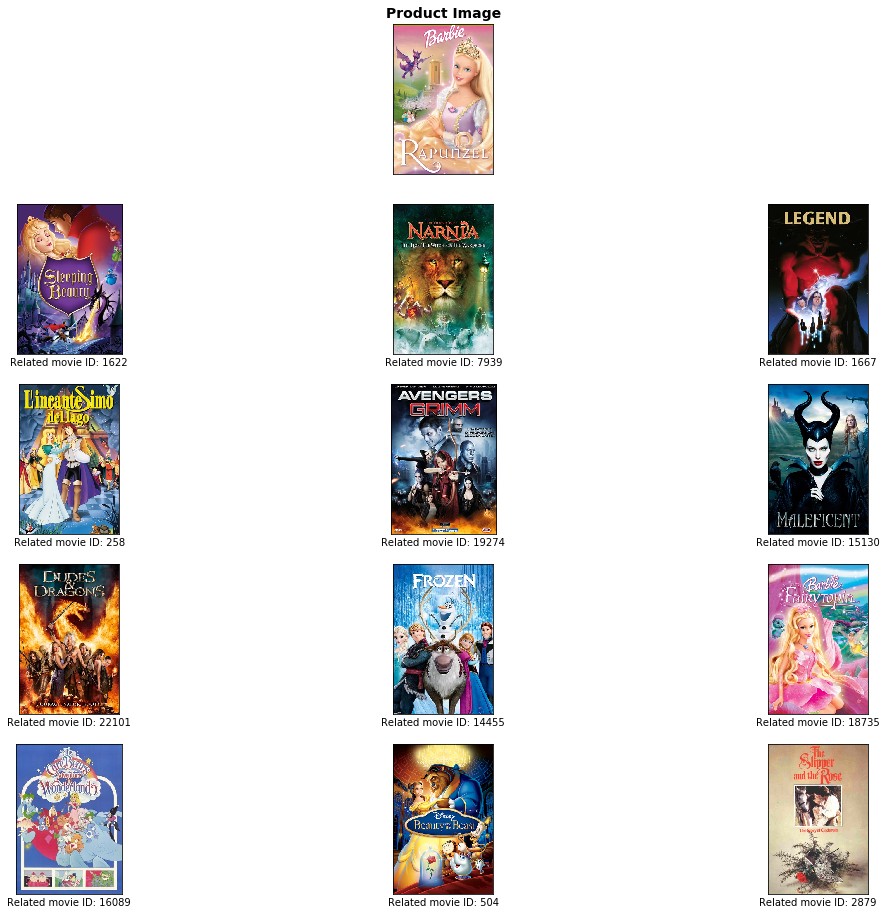

In [59]:
get_related_movies('tt0313255')